Use the models improved after build_models_04.ipynb to predict the bulk measurements into Avaatech resolution (10 mm).

In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Read spe dataset and models

In [2]:
spe_df = pd.read_csv('data/spe_dataset_20201008.csv', index_col = 0)
X = spe_df.iloc[:, :2048].values
X = X / X.sum(axis = 1, keepdims = True)

In [3]:
spe_df.columns[-5:]

Index(['core', 'composite_depth_mm', 'section_depth_mm', 'filename',
       'section'],
      dtype='object')

In [4]:
from joblib import load
m_caco3 = load('models/caco3_nmf+svr_model_20201013.joblib')
m_toc = load('models/toc_nmf+svr_model_20201013.joblib')
m_tc = load('models/tc_nmf+svr_model_20201013.joblib')

# Predict

In [5]:
y_caco3 = np.exp(m_caco3.predict(X))
y_toc = np.exp(m_toc.predict(X))
y_tc = np.exp(m_tc.predict(X))

# Build dataset

In [6]:
predict_df = spe_df.iloc[:, -5:].copy()
predict_df['CaCO3 prediction (%)'] = y_caco3
predict_df['TOC prediction (%)'] = y_toc
predict_df['TC prediction (%)'] = y_tc

# Check

In [11]:
mask = (predict_df['CaCO3 prediction (%)'] < 0) | (predict_df['TOC prediction (%)'] < 0) | (predict_df['TC prediction (%)'] < 0)

print('There are {} prediction having values below 0.'.format(len(predict_df[mask])))

There are 0 prediction having values below 0.


In [12]:
mask = (predict_df['CaCO3 prediction (%)'] > 100) | (predict_df['TOC prediction (%)'] > 100) | (predict_df['TC prediction (%)'] > 100)

print('There are {} ({:.1f} %) predictions having values over 100.'.format(len(predict_df[mask]), len(predict_df[mask])/len(predict_df)*100))

There are 43 (0.1 %) predictions having values over 100.


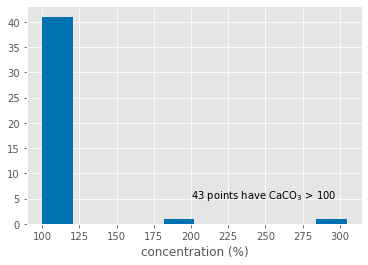

In [16]:
plt.hist(predict_df.loc[predict_df['CaCO3 prediction (%)'] > 100, 'CaCO3 prediction (%)'])
plt.text(200, 5, '{} points have CaCO{} > 100'.format(len(predict_df[predict_df['CaCO3 prediction (%)'] > 100]), r'${_3}$'));
plt.xlabel('concentration (%)');

The amount of unrealistic predeictions drops significantly after applying nature logrithm to the ys. Overall, the R-squared values are also better. I would simply delet the unrealistic data since they aren't too many.

# Export datset

In [24]:
mask = (predict_df['CaCO3 prediction (%)'] < 100) & (predict_df['TOC prediction (%)'] < 100) & (predict_df['TC prediction (%)'] < 100)
print('The remaining portion of the data: {:.1f} %'.format(len(predict_df[mask])/len(predict_df)*100))
predict_df.to_csv('results/prediction_{}.csv'.format(date))

The remaining portion of the data: 99.9 %
